In [ ]:
!pip install timm

In [1]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import \
    EngineConfigurationChannel
from mlagents_envs.exception import (
    UnityEnvironmentException,
    UnityCommunicationException,
    UnityCommunicatorStoppedException,
)
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import collections
from typing import Union
import math
import random
from copy import deepcopy
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt
import pandas as pd
import timm

/home/ym/.cache/pypoetry/virtualenvs/mlagent-learn-20-test-54-2MrXv-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
try:
    unity_env.close()
except Exception:
    pass

In [4]:
unity_env = UnityEnvironment(file_name=None)

In [5]:
unity_env.reset()

In [6]:
# env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)

In [7]:
# Unity環境のリセット
unity_env.reset()

# BehaviorNameのリストの取得
behavior_names = list(unity_env.behavior_specs.keys())
print('behavior_names:', behavior_names)

# BehaviorSpecの取得
behavior_spec = unity_env.behavior_specs[behavior_names[0]]

# BehaviorSpecの情報の確認
print('\n== BehaviorSpecの情報の確認 ==')
print('observation_specs:', behavior_spec.observation_specs)
print('action_spec:', behavior_spec.action_spec)

behavior_names: ['My Behavior?team=0']

== BehaviorSpecの情報の確認 ==
observation_specs: [ObservationSpec(shape=(224, 224, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='CameraSensor'), ObservationSpec(shape=(22,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='RayPerceptionSensor'), ObservationSpec(shape=(1,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size1')]
action_spec: Continuous: 0, Discrete: (4,)


In [8]:
# 現在のステップの情報の取得
decision_steps, terminal_steps = unity_env.get_steps(behavior_names[0])

# DecisionStepsの情報の確認
print('\n== DecisionStepsの情報の確認 ==')
print('obj:', decision_steps.obs)
print('reward:', decision_steps.reward)
print('agent_id:', decision_steps.agent_id)
print('action_mask:', decision_steps.action_mask)

# TerminalStepsの情報の確認
print('\n== TerminalStepsの情報の確認 ==')
print('obs:', terminal_steps.obs)
print('reward:', terminal_steps.reward)
print('agent_id:', terminal_steps.agent_id)
print('interrupted:', terminal_steps.interrupted)


== DecisionStepsの情報の確認 ==
obj: [array([[[[0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         ...,
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ]],

        [[0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         ...,
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ]],

        [[0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         ...,
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ],
         [0.5647059 , 0.7372549 , 0.6039216 ]],

        ...,

        [[0.17254902, 0.19607843, 0.24705882],
         [0.

In [9]:
len(decision_steps.obs)

3

In [10]:
decision_steps.obs[0].shape

(1, 224, 224, 3)

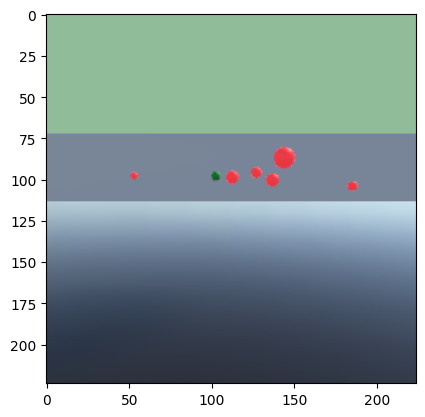

In [15]:
plt.imshow(decision_steps.obs[0][0, :, :, :])
plt.show()

In [16]:
decision_steps.obs[1]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]], dtype=float32)

In [18]:
decision_steps.obs[2]

array([[0.]], dtype=float32)

In [11]:
class ExpBuffer:

    def __init__(
        self,
        max_size: int = 20000,
        prob_alpha: float = 0.6,
        beta_start: float = 0.4,
        beta_frames: float = 100000,
        n_step: int = 4,
        gamma: float = 0.99,
    ):
        self._prob_alpha = prob_alpha
        self._max_size = max_size
        self._buf = []
        self._pos = 0
        self._beta_start = beta_start
        self._beta = beta_start
        self._beta_frames = beta_frames
        self._n_step = n_step
        self._gamma = gamma
        self._total_discounted_rewards = np.array([np.nan]*max_size)
        self._last_states = [np.nan]*max_size

    def update_bata(self, idx) -> None:
        beta = self._beta_start + idx * (1.0 - self._beta_start) / self._beta_frames
        self._beta = min(1.0, beta)
        return self._beta

    def __len__(self):
        return len(self._buf)

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: Union[int, float],
        done: bool,
        next_state: np.ndarray,
    ) -> None:
        if len(self._buf) < self._max_size:
            self._buf.append(
                (state, action, reward, done, next_state)
            )
        else:
            self._buf[self._pos] = (state, action, reward, done, next_state)

        if len(self._buf) >= self._n_step:
            dis_r = 0.0
            last_state = self._buf[self._pos][0]
            for i in range(self._n_step):
                state, _, r, done, _ = self._buf[self._pos - i]
                dis_r = r + self._gamma * dis_r
                if done:
                    last_state = state
                    dis_r = r  # ※
                self._total_discounted_rewards[self._pos - i] = dis_r
                self._last_states[self._pos - i] = last_state
            
            for i in range(self._n_step-1):
                done = self._buf[self._pos - i][3]
                if done:
                    break
                self._total_discounted_rewards[self._pos - i] = np.nan
                self._last_states[self._pos - i] = np.nan

        self._pos = (self._pos + 1) % self._max_size

    def get_latest_n(self, n: int):
        if len(self._buf) < self._max_size:
            if len(self._buf) < n+self._n_step:
                raise RuntimeError('get_latest_n : len(self._buf) < n+self._n_step')
            s_idx = self._pos - self._n_step - n 
            e_idx = self._pos - self._n_step
            latest_exps = self._buf[s_idx:e_idx]
            latest_total_rewards = self._total_discounted_rewards[s_idx:e_idx]
            latest_last_states = self._last_states[s_idx:e_idx]
        else:
            s_idx = self._pos + self._max_size - self._n_step - n
            e_idx = self._pos + self._max_size - self._n_step
            latest_exps = (self._buf*2)[s_idx:e_idx]
            latest_total_rewards = np.concatenate([self._total_discounted_rewards]*2)[s_idx:e_idx]
            latest_last_states = (self._last_states*2)[s_idx:e_idx]
        if len(latest_total_rewards) != n:
            print(f'{s_idx} : {e_idx} : {e_idx-s_idx} : {len((self._total_discounted_rewards*2))}')
        assert len(latest_exps) == n
        assert len(latest_total_rewards) == n
        assert len(latest_last_states) == n
        states, actions, rewards, dones, next_states = zip(*latest_exps)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        next_states = np.array(next_states)
        last_states = np.stack(latest_last_states)
        return states, actions, rewards, dones, latest_total_rewards, last_states

    def update_priorities(self, sample_indices: np.ndarray, sample_priorities: np.ndarray) -> None:
        self._priorities[sample_indices] = sample_priorities

    @property
    def gamma(self) -> float:
        return self._gamma

    @property
    def n_step(self) -> float:
        return self._n_step

In [12]:
class ModelActor(nn.Module):
    def __init__(self, input_shape, act_size, hidden_size = 64):
        super(ModelActor, self).__init__()

        self._conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_dim = int(np.prod(
            self._conv(torch.zeros(1, *input_shape)).size()
        ))
        
        self.mu = nn.Sequential(
            nn.Linear(conv_out_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, act_size),
#             nn.Tanh(),
            nn.Softmax(-1),
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        return self.mu(
            self._conv(x).reshape(x.size()[0], -1)
        )

class ModelCritic(nn.Module):
    def __init__(self, input_shape, hidden_size = 64):
        super(ModelCritic, self).__init__()

        self._conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_dim = int(np.prod(
            self._conv(torch.zeros(1, *input_shape)).size()
        ))
        
        self.value = nn.Sequential(
            nn.Linear(conv_out_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.value(
            self._conv(x).reshape(x.size()[0], -1)
        )

In [13]:
class ModelActorSwin(nn.Module):
    def __init__(self, input_shape, act_size, hidden_size = 64):
        super(ModelActorSwin, self).__init__()

        model_name = 'swin_tiny_patch4_window7_224'
        self._conv = timm.create_model(model_name, pretrained=True)
        self._conv.head.fc = nn.Identity()

        conv_out_dim = int(np.prod(
            self._conv(torch.zeros(1, *input_shape)).size()
        ))
        
        self.mu = nn.Sequential(
            nn.Linear(conv_out_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, act_size),
#             nn.Tanh(),
            nn.Softmax(-1),
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        return self.mu(
            self._conv(x).reshape(x.size()[0], -1)
        )

class ModelCriticSwin(nn.Module):
    def __init__(self, input_shape, hidden_size = 64):
        super(ModelCriticSwin, self).__init__()

        model_name = 'swin_tiny_patch4_window7_224'
        self._conv = timm.create_model(model_name, pretrained=True)
        self._conv.head.fc = nn.Identity()

        conv_out_dim = int(np.prod(
            self._conv(torch.zeros(1, *input_shape)).size()
        ))
        
        self.value = nn.Sequential(
            nn.Linear(conv_out_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.value(
            self._conv(x).reshape(x.size()[0], -1)
        )

In [14]:
def calc_adv_ref(rewards, dones, net_crt, states_v, gamma, gae_lambda, batch_size, device="cpu"):
    # values_v = net_crt(states_v)
    values_v = torch.cat([net_crt(states_v[batch_ofs:batch_ofs+batch_size]) for batch_ofs in range(0, states_v.shape[0], batch_size)], 0)
    values = values_v.squeeze().data.cpu().numpy()

    last_gae = 0.0
    result_adv = []
    result_ref = []
    for val, next_val, reward, done in zip(reversed(values[:-1]),
                                     reversed(values[1:]),
                                     reversed(rewards[:-1]),
                                     reversed(dones[:-1])):
        if done:
            delta = reward - val
            last_gae = delta
        else:
            delta = reward + gamma * next_val - val
            last_gae = delta + gamma * gae_lambda * last_gae
        result_adv.append(last_gae)
        result_ref.append(last_gae + val)

    adv_v = torch.FloatTensor(list(reversed(result_adv)))
    ref_v = torch.FloatTensor(list(reversed(result_ref)))
    return adv_v.to(device), ref_v.to(device)

In [15]:
def calc_logprob(mu_v, logstd_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*torch.exp(logstd_v).clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * math.pi * torch.exp(logstd_v)))
    return p1 + p2

In [16]:
class Agent:

    def __init__(
        self,
        env,
        exp_buffer: ExpBuffer,
        act_net: nn.Module,
        crt_net: nn.Module,
        epsilon_start: float = 1.0,
        epsilon_final: float = 0.01,
        epsilon_decay_last_step: int = 200000,
        act_learning_rate: float = 1e-5,
        crt_learning_rate: float = 1e-4,
        adam_eps: float = None,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        trajectory_size: int = 2049,
        ppo_eps: float = 0.2,
        gae_lambda: float = 0.95,
    ):
        self._env = env
        self._exp_buffer = exp_buffer
        self._act_net = act_net
        self._crt_net = crt_net
        self._epsilon_start = epsilon_start
        self._epsilon_final = epsilon_final
        self._epsilon_decay_last_step = epsilon_decay_last_step
        self._epsilon = epsilon_start
        self._device = device
        self._total_step = 0
        self._total_trained_samples = 0
        # self._tgt_sync_steps = tgt_sync_steps
        adam_kwargs = {}
        if adam_eps is not None:
            adam_kwargs['eps'] = adam_eps
        self._act_optimizer = torch.optim.Adam(self._act_net.parameters(), lr=act_learning_rate, **adam_kwargs)
        self._crt_optimizer = torch.optim.Adam(self._crt_net.parameters(), lr=crt_learning_rate, **adam_kwargs)
        self._reset_episode()
        # self._use_sync_net = use_sync_net
        self._episode = 0
        self._trajectory_size = trajectory_size
        self._ppo_eps = ppo_eps
        self._gae_lambda = gae_lambda

    def _reset_episode(self):
        self._state = self._env.reset()
        self._total_reward = 0.0

    @torch.no_grad()
    def play_step(self, epsilon: Optional[float] = None, sync_target: bool = True):
        if epsilon is None:
            epsilon = self._epsilon
        done_reward = None

        if np.random.random() < epsilon:
            action = self._env.action_space.sample()
        else:
            state_a = np.array([self._state], copy=False)
            state_v = torch.tensor(state_a).float().to(self._device)
            prob_v = self._act_net(state_v)
#             action = prob_v.squeeze(dim=0).argmax().data.cpu().numpy()
            prob = prob_v.squeeze(dim=0).data.cpu().numpy()
            action = np.random.choice(range(len(prob)), size=1, p=prob).astype(int)[0]
#             print(action)
#             action = np.clip(action, -1, 1)

        next_state, reward, is_done, _ = self._env.step(action)
        self._total_reward += reward

        self._exp_buffer.append(
            self._state, action, reward, is_done, next_state
        )
        self._state = next_state
        if is_done:
            done_reward = self._total_reward
            self._reset_episode()

        self._total_step += 1
        self._update_epsilon(self._total_step)
        self._exp_buffer.update_bata(self._total_step)

        # if self._total_step % self._tgt_sync_steps == 0 and sync_target:
        #     self._tgt_net.load_state_dict(self._net.state_dict())
        #     print(f'synced target net')

        return done_reward

    def train(self, ppo_epoch: int = 10, batch_size: int = 32) -> None:
        n_step_gamma = self._exp_buffer.gamma ** self._exp_buffer.n_step

        for stp in range(self._trajectory_size):
            done_reward = self.play_step()
            if done_reward is not None:
                print(f'episode : {self._episode}, done reward : {done_reward}, total_step : {self._total_step}, cur_epsilon : {self._epsilon}')
                self._episode += 1
        traj_states, traj_actions, traj_rewards, traj_dones, traj_total_discounted_rewards, \
            traj_last_states = self._exp_buffer.get_latest_n(self._trajectory_size)
        traj_states_v = torch.tensor(traj_states).float().to(self._device)
        traj_actions_v = torch.tensor(traj_actions).to(self._device)
        traj_discounted_rewards_v = torch.tensor(traj_total_discounted_rewards).to(self._device)
        traj_done_mask = torch.BoolTensor(traj_dones).to(self._device)
        # weights_v = torch.tensor(weights).to(self._device)

        with torch.no_grad():
            traj_adv_v, traj_ref_v = calc_adv_ref(
                traj_total_discounted_rewards, traj_dones, self._crt_net, traj_states_v,
                gamma=n_step_gamma, gae_lambda=self._gae_lambda, batch_size=batch_size, device=self._device  # reards or total_discounted_rewards ?
            )
            # traj_prob_v = self._act_net(traj_states_v)  # 変更要
            traj_prob_v = torch.cat([self._act_net(traj_states_v[batch_ofs:batch_ofs+batch_size]) for batch_ofs in range(0, traj_states_v.shape[0], batch_size)], 0)
    #         old_logprob_v = calc_logprob(mu_v, self._act_net.logstd, traj_actions_v)
    #         action_prob_v = prob_v.max(1)[0]
            traj_action_prob_v = traj_prob_v.gather(1, traj_actions_v.unsqueeze(-1))
            old_logprob_v = torch.log(traj_action_prob_v)

            # normalize advantages
            traj_adv_v = traj_adv_v - torch.mean(traj_adv_v)
            traj_adv_v /= torch.std(traj_adv_v)

            # drop last entry from the trajectory, an our adv and ref value calculated without it
            # trajectory = trajectory[:-1]
            old_logprob_v = old_logprob_v[:-1].detach()

        sum_loss_value = 0.0
        sum_loss_policy = 0.0
        count_steps = 0
        
        self._crt_net.train()
        self._act_net.train()

        for epoch in range(ppo_epoch):
            for batch_ofs in range(0, self._trajectory_size-1, batch_size):
                batch_l = batch_ofs + batch_size
                states_v = traj_states_v[batch_ofs:batch_l]
                actions_v = traj_actions_v[batch_ofs:batch_l]
                batch_adv_v = traj_adv_v[batch_ofs:batch_l]
                batch_adv_v = batch_adv_v.unsqueeze(-1)
                batch_ref_v = traj_ref_v[batch_ofs:batch_l]
                batch_old_logprob_v = old_logprob_v[batch_ofs:batch_l]

                # critic training
                self._crt_optimizer.zero_grad()
                value_v = self._crt_net(states_v)
                loss_value_v = F.mse_loss(value_v.squeeze(-1), batch_ref_v)
                loss_value_v.backward()
                self._crt_optimizer.step()

                # actor training
                self._act_optimizer.zero_grad()
                prob_v = self._act_net(states_v)  # 変更要
#                 action_prob_v = prob_v.max(1)[0]
                action_prob_v = prob_v.gather(1, actions_v.unsqueeze(-1))
#                 logprob_pi_v = calc_logprob(mu_v, self._act_net.logstd, actions_v)
                logprob_pi_v = torch.log(action_prob_v)
                ratio_v = torch.exp(logprob_pi_v - batch_old_logprob_v)
                surr_obj_v = batch_adv_v * ratio_v
                c_ratio_v = torch.clamp(ratio_v, 1.0 - self._ppo_eps, 1.0 + self._ppo_eps)
                clipped_surr_v = batch_adv_v * c_ratio_v
                loss_policy_v = -torch.min(surr_obj_v, clipped_surr_v).mean()
                loss_policy_v.backward()
                self._act_optimizer.step()

                sum_loss_value += loss_value_v.item()
                sum_loss_policy += loss_policy_v.item()
                count_steps += 1

        # self._exp_buffer.update_priorities(sampled_indices, prios)
        self._total_trained_samples += batch_size

    def initial_exploration(self, n_steps: int = 10000, epsilon: float = 1.0) -> None:
        eps_bak = self._epsilon
        total_step_bak = self._total_step
        for i in pb(range(n_steps)):
            self._epsilon = epsilon
            self.play_step(sync_target=False)
        self._total_step = total_step_bak
        self._epsilon = eps_bak

    def simulate_episode(self) -> float:
        eps_bak = self._epsilon
        total_step_bak = self._total_step
        while True:
            self._epsilon = 0.0
            done_reward = self.play_step(sync_target=False)
            if done_reward is not None:
                break
        self._total_step = total_step_bak
        self._epsilon = eps_bak
        return done_reward

    def _update_epsilon(self, step_index: int) -> None:
        self._epsilon = max(
            self._epsilon_final,
            self._epsilon_start - step_index / self._epsilon_decay_last_step
        )

In [17]:
class UnityToGymNumpyImgWrapper(UnityToGymWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return np.array(state[0]).transpose(2, 0, 1)

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        return np.array(next_state[0]).transpose(2, 0, 1), reward, is_done, info

In [18]:
class UnityToGymNumpyImgResizeWrapper(UnityToGymNumpyImgWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgResizeWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
#         return cv2.resize(state[:, :, 10:-10].transpose(1, 2, 0), (224, 224)).transpose(2, 0, 1)
        # return state[:, :, 10:-10]
        return state

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        next_state = cv2.resize(next_state[:, :, 10:-10].transpose(1, 2, 0), (224, 224)).transpose(2, 0, 1)
        return next_state, reward, is_done, info
        # return next_state[:, :, 10:-10], reward, is_done, info

In [19]:
class UnityToGymNumpyImgResizeGrayWrapper(UnityToGymNumpyImgWrapper):
    def __init__(self, *args, **kwargs):
        super(UnityToGymNumpyImgResizeGrayWrapper, self).__init__(*args, **kwargs)

    def reset(self, *args, **kwargs):
        state = super().reset(*args, **kwargs)
        return cv2.cvtColor(state[:, :, 10:-10].transpose(1, 2, 0), cv2.COLOR_RGB2GRAY).reshape(1, 64, 64)
#         return state[:, :, 10:-10]

    def step(self, *args, **kwargs):
        next_state, reward, is_done, info = super().step(*args, **kwargs)
        next_state = cv2.cvtColor(next_state[:, :, 10:-10].transpose(1, 2, 0), cv2.COLOR_RGB2GRAY).reshape(1, 64, 64)
#         return next_state, reward, is_done, info
        return next_state, reward, is_done, info

In [20]:
N_AGENTS = decision_steps.obs[0].shape[0]

In [21]:
N_AGENTS

1

In [22]:
N_ACTIONS = behavior_spec.action_spec.discrete_branches[0]

In [23]:
N_ACTIONS

4

In [24]:
env = UnityToGymNumpyImgResizeWrapper(unity_env, allow_multiple_obs=True)

In [25]:
env.action_space

Discrete(4)

In [26]:
env.observation_space

Tuple(Box(0.0, 1.0, (224, 224, 3), float32), Box(-inf, inf, (23,), float32))

In [27]:
state = env.reset()

In [28]:
state.shape

(3, 224, 224)

In [32]:
OBS_DIM = state.shape

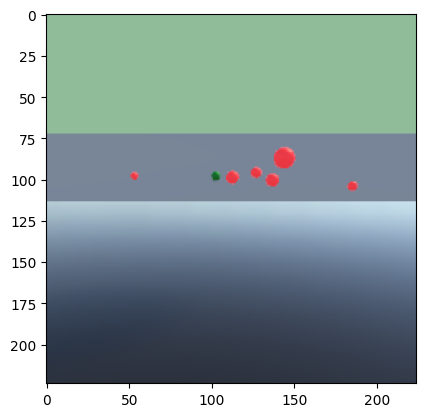

In [30]:
plt.imshow(state.transpose(1, 2, 0))

In [29]:
SEED = 77

In [30]:
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# act_net = ModelActor(OBS_DIM, N_ACTIONS).to(device)
# crt_net = ModelCritic(OBS_DIM).to(device)
act_net = ModelActorSwin(OBS_DIM, N_ACTIONS).to(device)
crt_net = ModelCriticSwin(OBS_DIM).to(device)

/home/ym/.cache/pypoetry/virtualenvs/mlagent-learn-20-test-54-2MrXv-py3.9/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [33]:
# act_net(torch.tensor(state).unsqueeze(0).to(device))

In [32]:
# crt_net(torch.tensor(state).unsqueeze(0).to(device))

tensor([[-0.0799]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [34]:
exp_buffer = ExpBuffer(
    # max_size=20000,
    max_size=2500,
    prob_alpha=0.6,
    beta_start=0.4,
    beta_frames=30000, #100000,
    n_step=1,
    gamma=0.99,
)

In [35]:
agent = Agent(
    env=env,
    exp_buffer=exp_buffer,
    crt_net=crt_net,
    act_net=act_net,
    epsilon_start=0.6,
    epsilon_final=0.002,
    epsilon_decay_last_step=30000, #200000,
    # tgt_sync_steps=1000,
    act_learning_rate=1e-5,
    crt_learning_rate=1e-4,
    device=device,
    trajectory_size=2049,
    ppo_eps=0.2,
    gae_lambda=0.95,
)

In [36]:
agent.initial_exploration(n_steps=100)

In [37]:
states, actions, rewards, dones, next_states = zip(*agent._exp_buffer._buf)

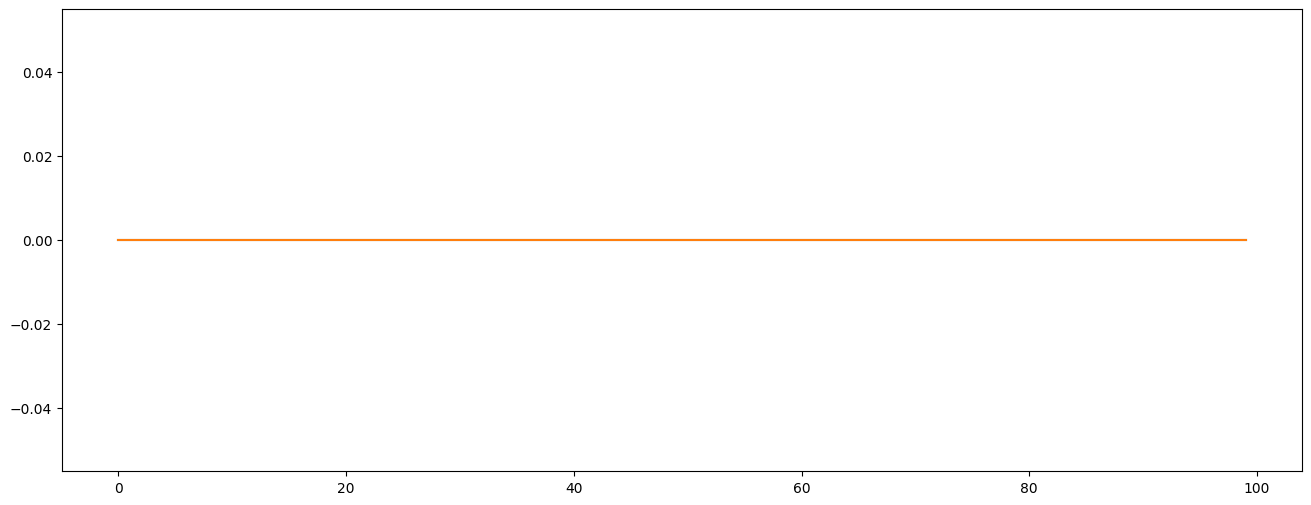

In [38]:
plt.figure(figsize=(16, 6))
plt.plot(rewards[:200])
plt.plot(agent._exp_buffer._total_discounted_rewards[:200])

In [39]:
episode = 0

while True:
    agent.train(ppo_epoch=4, batch_size=16)

episode : 0, done reward : 2.0, total_step : 1900, cur_epsilon : 0.5366666666666666
episode : 1, done reward : -1.0, total_step : 3900, cur_epsilon : 0.47
episode : 2, done reward : 3.0, total_step : 5900, cur_epsilon : 0.4033333333333333
episode : 3, done reward : 2.0, total_step : 7900, cur_epsilon : 0.33666666666666667
episode : 4, done reward : 8.0, total_step : 9900, cur_epsilon : 0.26999999999999996
episode : 5, done reward : 15.0, total_step : 11900, cur_epsilon : 0.2033333333333333
episode : 6, done reward : 4.0, total_step : 13900, cur_epsilon : 0.13666666666666666
episode : 7, done reward : 10.0, total_step : 15900, cur_epsilon : 0.06999999999999995
episode : 8, done reward : 7.0, total_step : 17900, cur_epsilon : 0.0033333333333332993
episode : 9, done reward : 13.0, total_step : 19900, cur_epsilon : 0.002
episode : 10, done reward : 8.0, total_step : 21900, cur_epsilon : 0.002
episode : 11, done reward : 7.0, total_step : 23900, cur_epsilon : 0.002
episode : 12, done reward

KeyboardInterrupt: 

In [41]:
episode = 0

while True:
    agent.train(ppo_epoch=10, batch_size=32)

episode : 0, done reward : 2.0, total_step : 1900, cur_epsilon : 0.5366666666666666
episode : 1, done reward : 1.0, total_step : 3900, cur_epsilon : 0.47
episode : 2, done reward : 0.0, total_step : 5900, cur_epsilon : 0.4033333333333333
episode : 3, done reward : 0.0, total_step : 7900, cur_epsilon : 0.33666666666666667
episode : 4, done reward : -3.0, total_step : 9900, cur_epsilon : 0.26999999999999996
episode : 5, done reward : 6.0, total_step : 11900, cur_epsilon : 0.2033333333333333
episode : 6, done reward : 4.0, total_step : 13900, cur_epsilon : 0.13666666666666666
episode : 7, done reward : 2.0, total_step : 15900, cur_epsilon : 0.06999999999999995
episode : 8, done reward : 4.0, total_step : 17900, cur_epsilon : 0.0033333333333332993
episode : 9, done reward : 10.0, total_step : 19900, cur_epsilon : 0.002
episode : 10, done reward : 13.0, total_step : 21900, cur_epsilon : 0.002
episode : 11, done reward : 18.0, total_step : 23900, cur_epsilon : 0.002
episode : 12, done reward

KeyboardInterrupt: 

In [44]:
torch.save(act_net.state_dict(), 'tmp_food_collect_actor.pth')

In [45]:
torch.save(crt_net.state_dict(), 'tmp_food_collect_critic.pth')

In [42]:
env.close()

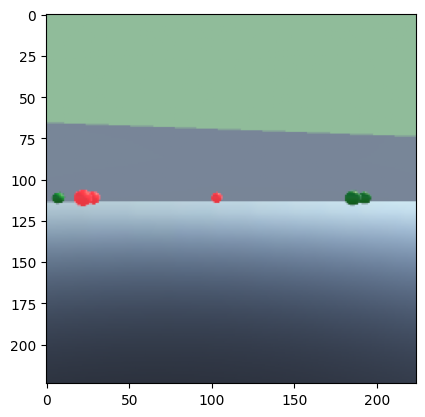

In [27]:
plt.imshow(next_state[0])
plt.show()

In [28]:
env.close()